In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.inspection import DecisionBoundaryDisplay
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
from sklearn.datasets import make_moons

In [2]:
'''
# Génération de données en 2D
X, y, centers = make_blobs(n_samples=400, centers=4, n_features=2, random_state=0, return_centers=True, center_box=(-20.0, 20.0))
X2, y2, centers2 = make_blobs(n_samples=100, centers=1, n_features=2, random_state=2, return_centers=True, center_box=(-20.0, 20.0), cluster_std=2)
X = np.vstack((X, X2))
y = np.zeros(X.shape[0])
print("Shape de X: ", X.shape)
print("Centroides: \n", centers)

# Affichage des données
plt.plot(X[:, 0][y==1], X[:, 1][y==1],'g^', )
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'g^')


plt.show()
'''

'\n# Génération de données en 2D\nX, y, centers = make_blobs(n_samples=400, centers=4, n_features=2, random_state=0, return_centers=True, center_box=(-20.0, 20.0))\nX2, y2, centers2 = make_blobs(n_samples=100, centers=1, n_features=2, random_state=2, return_centers=True, center_box=(-20.0, 20.0), cluster_std=2)\nX = np.vstack((X, X2))\ny = np.zeros(X.shape[0])\nprint("Shape de X: ", X.shape)\nprint("Centroides: \n", centers)\n\n# Affichage des données\nplt.plot(X[:, 0][y==1], X[:, 1][y==1],\'g^\', )\nplt.plot(X[:, 0][y==0], X[:, 1][y==0], \'g^\')\n\n\nplt.show()\n'

centers:  [[ 18.3097667  -16.9325279 ]
 [ 19.65659573   1.8633086 ]
 [ 12.88843517  -1.66796976]
 [ -6.47621599  -0.33867182]]


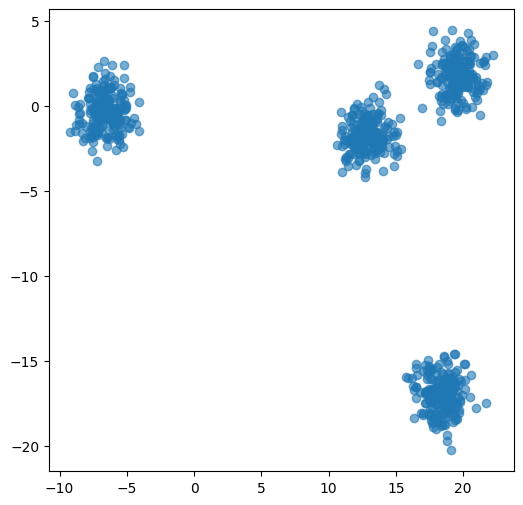

In [3]:
def generate_spheres(nb_clusters, nb_points, nb_dim, radius):
    X = np.zeros((nb_clusters*nb_points, nb_dim))
    y = np.zeros(nb_clusters*nb_points)
    centers = np.zeros((nb_clusters, nb_dim))
    for i in range(nb_clusters):
        # Générer un centre aléatoire
        centers[i] = np.random.uniform(-radius, radius, nb_dim)
        # Générer des points autour du centre
        X[i*nb_points:(i+1)*nb_points, :] = np.random.normal(centers[i], 1, (nb_points, nb_dim))
        # Affecter le label du cluster
        y[i*nb_points:(i+1)*nb_points] = i
    return X, y, centers

X, y, centers = generate_spheres(4, 200, 2, 20)
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
print("centers: ", centers)

# 1.1 C-moyennes floues

In [4]:
def c_moy_floue_apprentissage(X, nb_clusters, nb_iter=10, m=2):
    nb_points = X.shape[0]
    nb_dim = X.shape[1]
    # Initialisation des centres des clusters
    ind = np.random.randint(0,X.shape[0], nb_clusters)
    W = X[ind, :]
    eps = 10e-8
    print("Centres initiaux: \n", W)
    # Initialisation des distances entre les points et les centres des clusters
    D = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            D[i, j] = np.linalg.norm(X[i] - W[j])
    #  Initialisation des degrés d'appartenance des points aux clusters
    U = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            U[i, j] = 1 / (np.sum((D[i, j] / (D[i, :]+eps)) ** (2 / (m - 1)))+eps)
    # Boucle principale
    for t in range(nb_iter):
        # Mise à jour des centres des clusters
        for j in range(nb_clusters):
            W[j] = np.sum(U[:, j] ** m * X.T, axis=1) / np.sum(U[:, j] ** m)
        # Mise à jour des distances
        for i in range(nb_points):
            for j in range(nb_clusters):
                D[i, j] = np.linalg.norm(X[i] - W[j])

        # Mise à jour des degrés d'appartenance
        for i in range(nb_points):
            for j in range(nb_clusters):
                U[i, j] = 1 / np.sum((D[i, j] / D[i, :]) ** (2 / (m - 1)))

    return W, U

Centres initiaux: 
 [[18.8782733   0.12319039]
 [19.25307062  2.02049765]
 [-5.91855103 -0.87368962]
 [10.96781164 -1.18670844]]
Centres finaux: 
 [[ 18.37038018 -16.95548904]
 [ 19.62002618   1.78750037]
 [ -6.57510384  -0.32721588]
 [ 12.83910329  -1.75788849]]


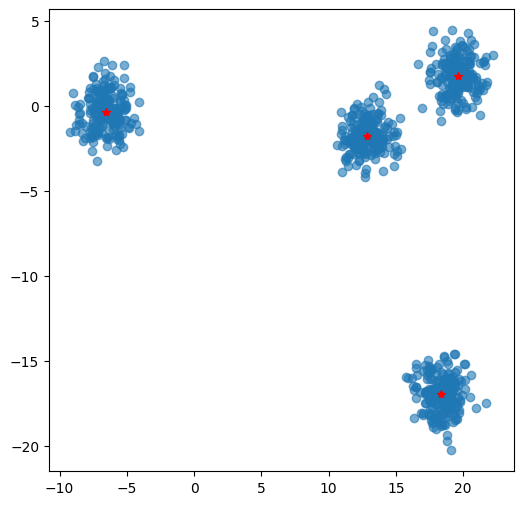

In [5]:
W,U = c_moy_floue_apprentissage(X, 4, nb_iter = 100, m=2)
print("Centres finaux: \n", W)

# Affichage des données
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
plt.plot(W[:, 0], W[:, 1], 'r*')
plt.show()

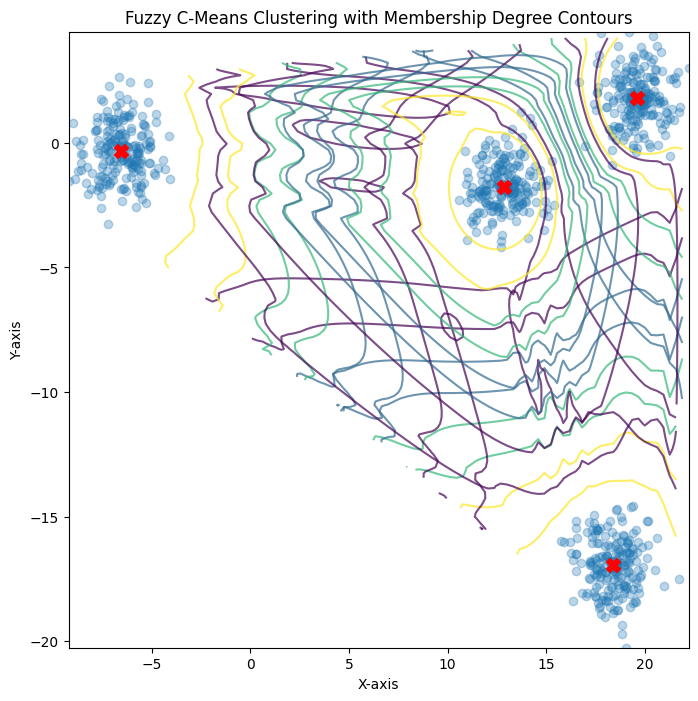

In [6]:
def plot_fuzzy_cmeans_contours(X, W, U, figsize=(8, 8), resolution=100):
    """
    Plots the data points, centroids of the fuzzy c-means clusters, and the membership degree contours for each cluster.

    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param W: Centroids of clusters, numpy array of shape (n_clusters, n_features).
    :param U: Membership degrees, numpy array of shape (n_samples, n_clusters).
    :param figsize: Size of the figure (width, height) in inches.
    :param resolution: Resolution for the meshgrid used in contour plots.
    """
    plt.figure(figsize=figsize)

    # Create a meshgrid for the contour plots
    x_min, y_min = np.min(X, axis=0)
    x_max, y_max = np.max(X, axis=0)
    x = np.linspace(x_min, x_max, resolution)
    y = np.linspace(y_min, y_max, resolution)
    X_mesh, Y_mesh = np.meshgrid(x, y)

    # Create a custom colormap
    cmap = ListedColormap(plt.cm.viridis(np.linspace(0, 1, W.shape[0])))

    # Plot contours for each cluster
    for j in range(W.shape[0]):
        # Interpolate membership degrees for cluster j
        Z = griddata(X, U[:, j], (X_mesh, Y_mesh), method='cubic')

        # Plot the membership degree contours for cluster j
        contour = plt.contour(X_mesh, Y_mesh, Z, levels=np.linspace(0, 1, 10), cmap=cmap, alpha=0.7)

    # Plot the data points and the centroids
    plt.scatter(X[:, 0], X[:, 1], alpha =0.3)
    plt.scatter(W[:, 0], W[:, 1], c='red', s=100, marker='X')

    # Labeling the plot
    plt.title("Fuzzy C-Means Clustering with Membership Degree Contours")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")

    plt.show()

# Example usage
# Assuming W and U are the outputs of your fuzzy c-means function for dataset X
plot_fuzzy_cmeans_contours(X, W, U)


# 1.2 C-moyenne floue probabiliste

In [7]:
def c_moy_floue_probabiliste(X,eta, W, nb_clusters, nb_iter=10, m=2):
    nb_points = X.shape[0]
    nb_dim = X.shape[1]
    print("Centres initiaux: \n", W)
    # Initialisation des distances entre les points et les centres des clusters
    D = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            D[i, j] = np.linalg.norm(X[i] - W[j])
    #  Initialisation des degrés d'appartenance des points aux clusters
    U = np.zeros((nb_points, nb_clusters))
    for i in range(nb_points):
        for j in range(nb_clusters):
            U[i, j] = 1 / 1 + ((D[i, j] / eta[j])** (2 / (m - 1)))


    # Boucle principale
    for t in range(nb_iter):
        # Mise à jour des centres des clusters
        for j in range(nb_clusters):
            W[j] = np.sum(U[:, j] ** m * X.T, axis=1) / np.sum(U[:, j] ** m)
            
        # Mise à jour des distances
        for i in range(nb_points):
            for j in range(nb_clusters):
                D[i, j] = np.linalg.norm(X[i] - W[j])

        # Mise à jour des degrés d'appartenance
        for i in range(nb_points):
            for j in range(nb_clusters):
                U[i, j] = 1 / 1 + ((D[i, j] / eta[j])** (2 / (m - 1)))

    return W, U

Centres initiaux: 
 [[ 19.09167718 -16.42714939]
 [ 12.95297771  -1.71607516]
 [ 13.56454906  -0.7797613 ]
 [ -7.23966536   1.05105066]]
Centres initiaux: 
 [[ 18.37038018 -16.95548904]
 [ 12.83910329  -1.75788849]
 [ 19.62002618   1.78750037]
 [ -6.57510384  -0.32721588]]
Centres finaux: 
 [[ 18.45782562 -10.5112411 ]
 [ 17.82338436  -7.59802661]
 [ 18.46505559  -8.57975973]
 [ -5.29995012  -0.37853749]]


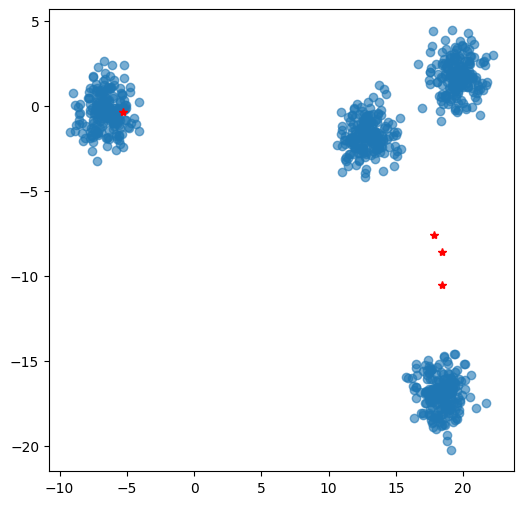

In [8]:
nb_clusters =4
eta = np.ones((nb_clusters))*2.5
W1,U1 = c_moy_floue_apprentissage(X, nb_clusters, nb_iter = 100, m=2)
#ind = np.random.randint(0,X.shape[0], nb_clusters)
#W = X[ind, :]
W2,U2 = c_moy_floue_probabiliste(X,eta,W1, nb_clusters, nb_iter = 2, m=2)
print("Centres finaux: \n", W2)

# Affichage des données
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
plt.plot(W2[:, 0], W2[:, 1], 'r*')
plt.show()


# 2. Comparaisons des resultats sur differents algorithmes de clustering

In [9]:
def pcm(X, nb_clusters, eta, nb_iter=100, m=2):
    """
    Possibilistic c-means clustering algorithm.

    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param nb_clusters: The number of clusters to form.
    :param eta: Typicality parameters for each cluster, numpy array of shape (nb_clusters,).
    :param nb_iter: Number of iterations to run.
    :param m: Fuzziness parameter.
    :return: Tuple (W, U) where W is an array of centroids and U is the matrix of typicalities.
    """
    nb_points, nb_dim = X.shape

    # Initialize cluster centers randomly from data points
    indices = np.random.choice(nb_points, nb_clusters, replace=False)
    W = X[indices, :]

    # Initialize the matrix of typicalities
    U = np.random.rand(nb_points, nb_clusters)
    U = U / np.sum(U, axis=1, keepdims=True)

    for iteration in range(nb_iter):
        # Update typicalities U
        for i in range(nb_points):
            for j in range(nb_clusters):
                dist = np.linalg.norm(X[i] - W[j])
                U[i, j] = 1 / (1 + (dist / eta[j]) ** (2 / (m - 1)))

        # Update cluster centers W
        for j in range(nb_clusters):
            numerator = np.sum(U[:, j] ** m * X.T, axis=1)
            denominator = np.sum(U[:, j] ** m)
            W[j] = numerator / denominator

        # Optional: Implement convergence check to break the loop if clusters do not change significantly

    return W, U

nb_clusters = 4
eta = np.array([1.5 for _ in range(nb_clusters)])  # Define eta for each cluster
W, U = pcm(X, nb_clusters=nb_clusters, eta=eta)
print("Centres finaux: \n", W)
print("Typicalités finales: \n", U)

Centres finaux: 
 [[ 18.41646436 -16.96769939]
 [ 19.59687314   1.7437056 ]
 [ 19.59687314   1.7437056 ]
 [ 12.88770791  -1.74256374]]
Typicalités finales: 
 [[0.82285609 0.00614863 0.00614863 0.00844897]
 [0.88688577 0.00640078 0.00640078 0.00833979]
 [0.21929145 0.00681182 0.00681182 0.01057796]
 ...
 [0.00267228 0.00351186 0.00351186 0.00655116]
 [0.00246204 0.00323795 0.00323795 0.00581889]
 [0.00246453 0.00307213 0.00307213 0.00550118]]


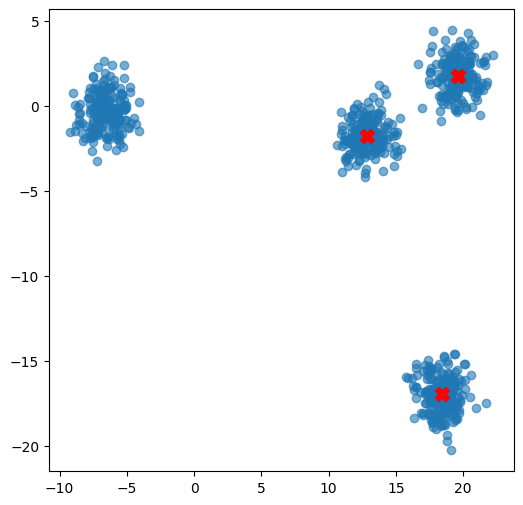

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
plt.scatter(W[:, 0], W[:, 1], c='red', s=100, marker='X')
plt.show()

In [11]:
km = KMeans(n_clusters=4, n_init=1, max_iter=100, tol=0.0001, random_state=0)
km.fit(X)
print("Inertia: ", km.inertia_)
print("Centroides: \n", km.cluster_centers_)
print("Nombre d'itérations: ", km.n_iter_)

Inertia:  1628.6983908338138
Centroides: 
 [[ 12.8579003   -1.74963984]
 [ -6.57483869  -0.32688898]
 [ 18.36891783 -16.9505168 ]
 [ 19.60177404   1.78023004]]
Nombre d'itérations:  2


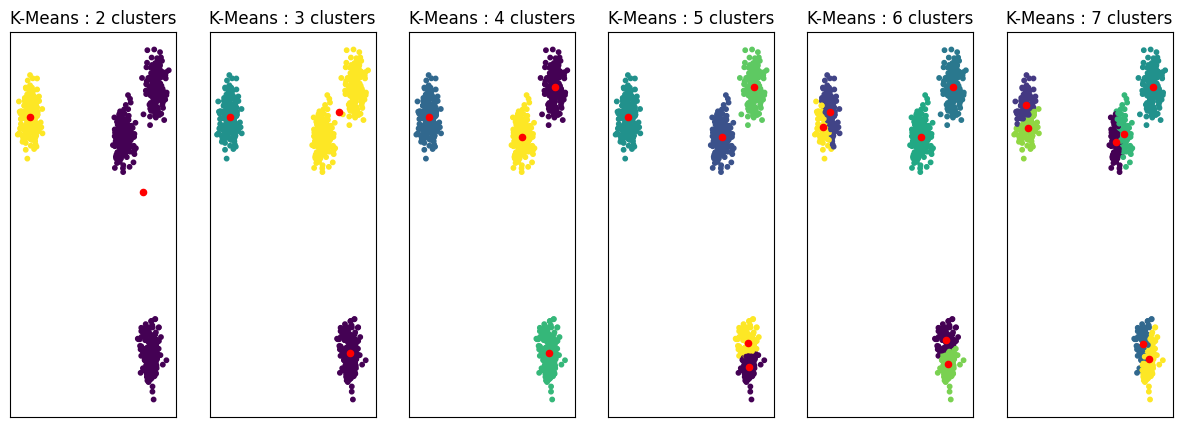

In [12]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(1, len(n_clusters_list), figsize=(15, 5))

for j, n_clusters in enumerate(n_clusters_list):
    for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
        algo = Algorithm(n_clusters=n_clusters, n_init=10, max_iter=300, tol=0.0001)
        algo.fit(X)
        centers = algo.cluster_centers_

        axs[j].scatter(X[:, 0], X[:, 1], s=10, c=algo.labels_)
        axs[j].scatter(centers[:, 0], centers[:, 1], c="r", s=20)

        axs[j].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


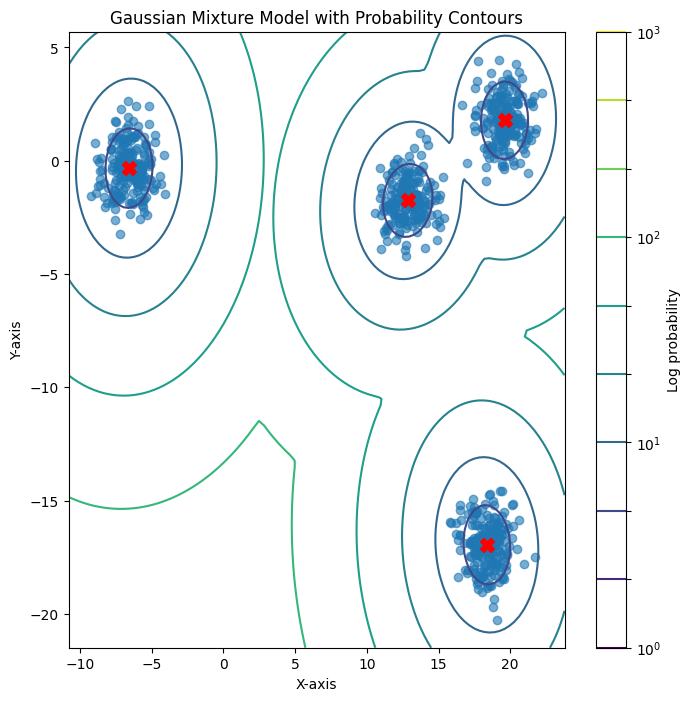

In [13]:
gm = GaussianMixture(n_components=4, n_init=10, max_iter=100, tol=0.0001, random_state=0)
gm.fit(X)

def plot_gmm_clusters_with_contours(gm, X, figsize=(8, 8), resolution=100):
    """
    Plots the data points, centroids of the GMM clusters, and the probability contours.

    :param gm: Fitted GaussianMixture object.
    :param X: Data points, numpy array of shape (n_samples, n_features).
    :param figsize: Size of the figure (width, height) in inches.
    :param resolution: Resolution for the meshgrid used in contour plots.
    """
    plt.figure(figsize=figsize)

    # Plot the data points and the centroids
    plt.scatter(X[:, 0], X[:, 1], alpha=0.6)
    plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c='red', s=100, marker='X')

    # Create a meshgrid for the contour plots
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], resolution)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], resolution)
    X_mesh, Y_mesh = np.meshgrid(x, y)
    XX = np.array([X_mesh.ravel(), Y_mesh.ravel()]).T

    # Calculate the log probabilities for each point in the meshgrid
    Z = -gm.score_samples(XX)
    Z = Z.reshape(X_mesh.shape)

    # Plot the probability contours
    plt.contour(X_mesh, Y_mesh, Z, levels=np.logspace(0, 3, 10), norm=LogNorm(vmin=1.0, vmax=1000.0), cmap='viridis')

    # Labeling the plot
    plt.title("Gaussian Mixture Model with Probability Contours")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.colorbar(label='Log probability')

    plt.show()

# Example usage
# Assuming gm is your fitted GaussianMixture model and X is your data
plot_gmm_clusters_with_contours(gm, X)


In [14]:
X, y = make_moons(n_samples=400, shuffle = True, noise=0.1)

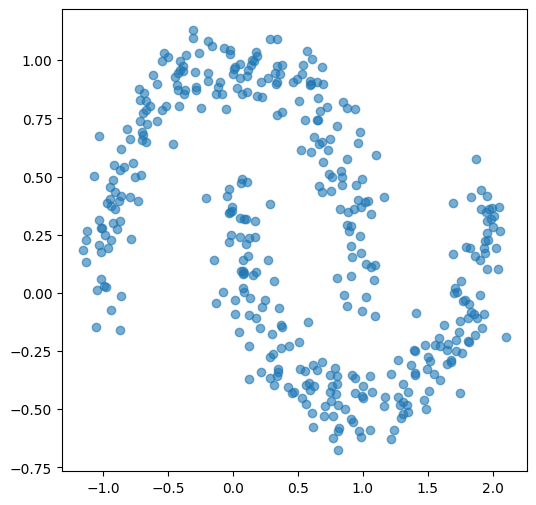

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)

Centres initiaux: 
 [[-0.81829836  0.70243132]
 [ 0.94103281 -0.43269081]]
Centres finaux: 
 [[-0.24635421  0.57331753]
 [ 1.22639253 -0.07725916]]


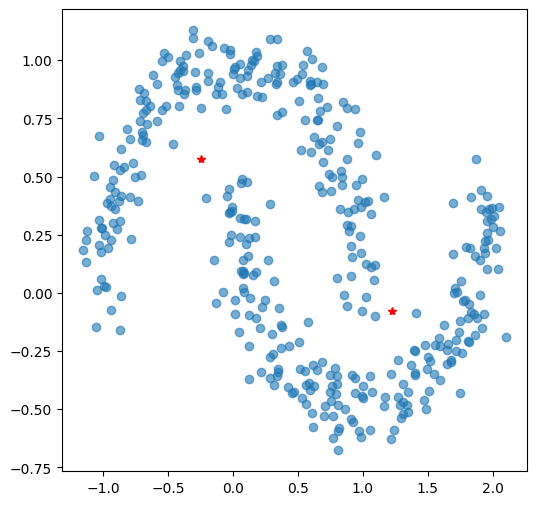

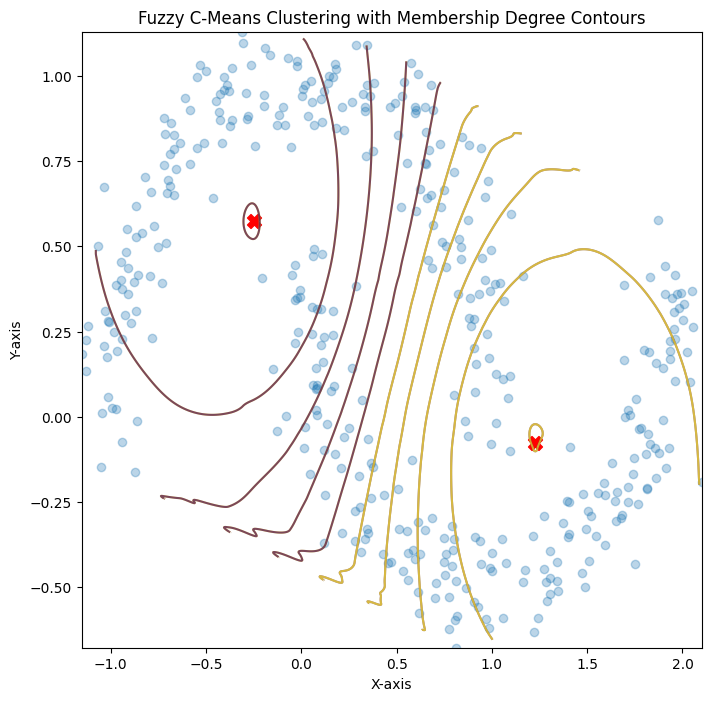

In [16]:
W,U = c_moy_floue_apprentissage(X, 2, nb_iter = 100, m=2)
print("Centres finaux: \n", W)

# Affichage des données
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
plt.plot(W[:, 0], W[:, 1], 'r*')
plt.show()
plot_fuzzy_cmeans_contours(X, W, U, figsize=(8, 8), resolution=1000)

## 2.2 Algorithme GMM

centers:  [[-17.86640361  -5.25142777]
 [  8.49110384   0.81710302]
 [-18.5913514  -16.13816953]
 [ -2.13316944  12.19789673]]


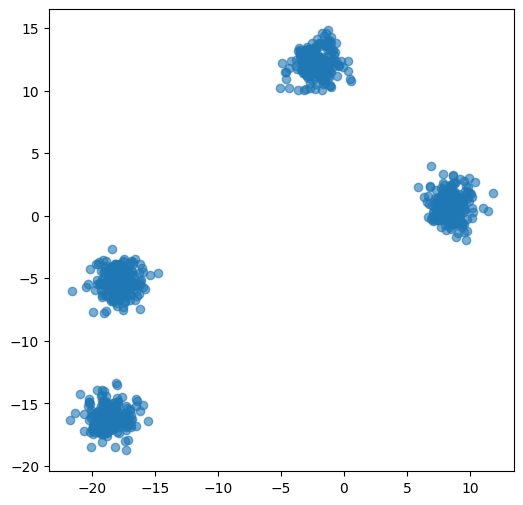

In [37]:
X, y, centers = generate_spheres(4, 200, 2, 20)
plt.figure(figsize=(6, 6))
plt.scatter(X[:,0],X[:,1] ,alpha=0.6)
print("centers: ", centers)

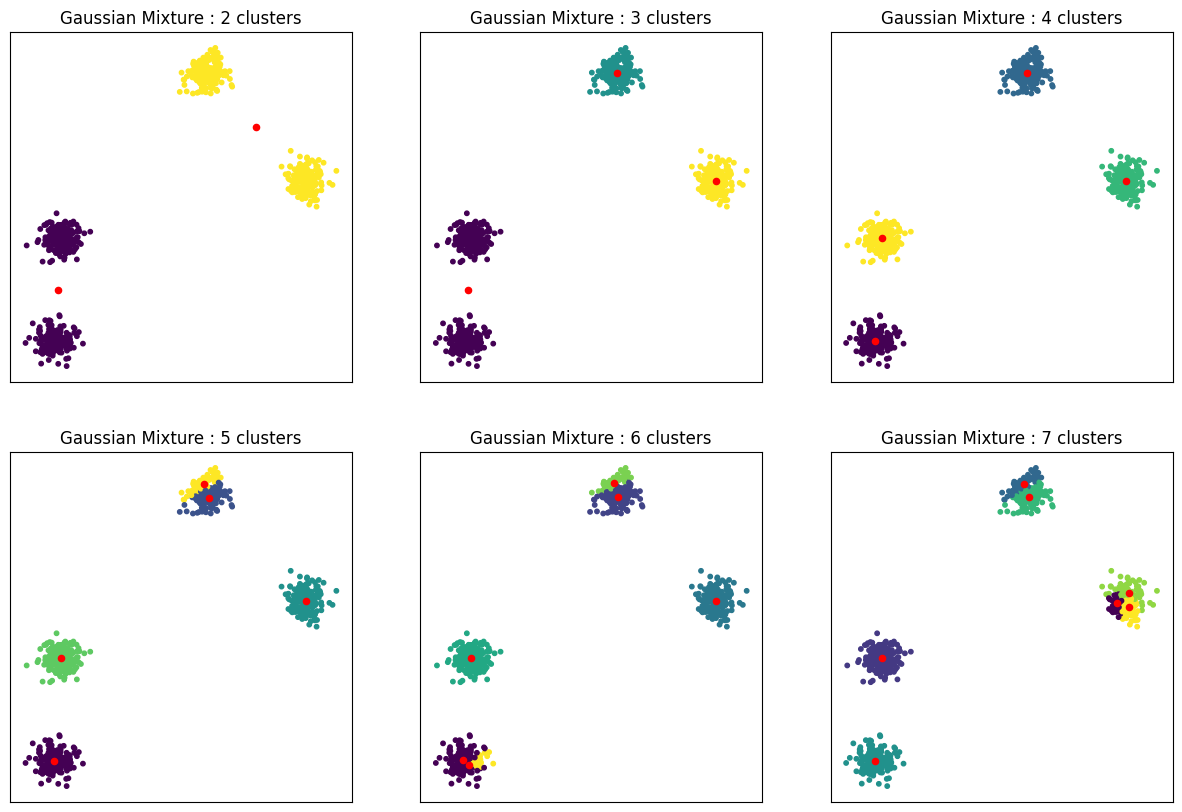

In [38]:
# Algorithms to compare
n_components_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_components_list) // 3 + (len(n_components_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n in enumerate(n_components_list):
        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=gm.predict(X))
        axs[row, col].scatter(means[:, 0], means[:, 1], c="r", s=20)

        axs[row, col].set_title(f"{algorithm_name} : {n} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


#### Avec les lignes de niveaux des fonctions d’affectation pondérée

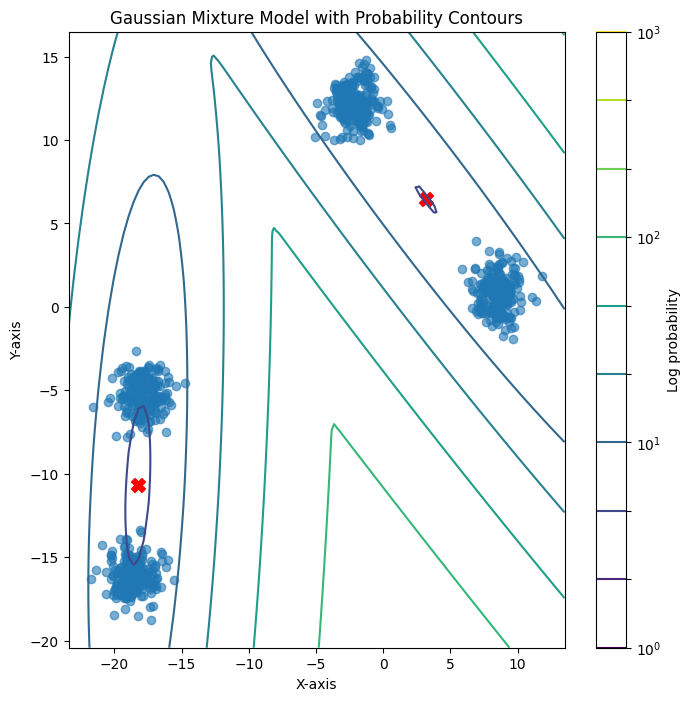

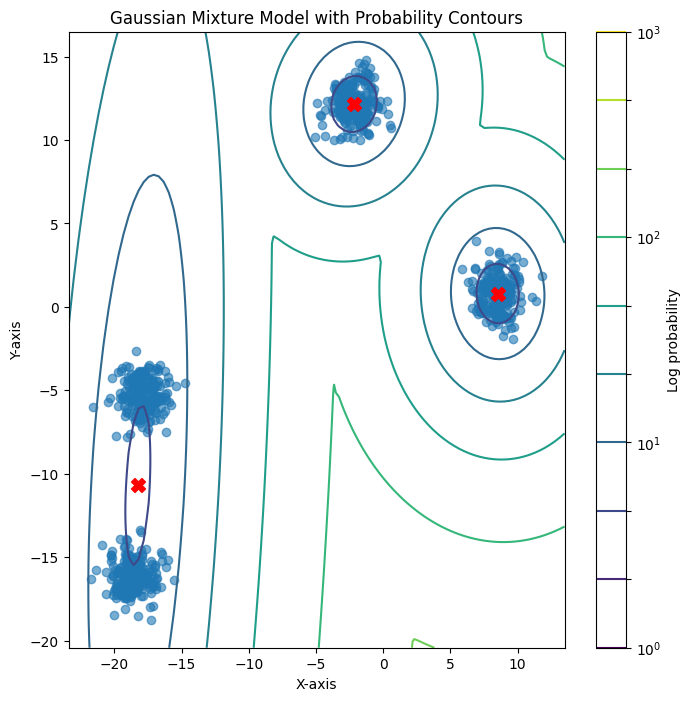

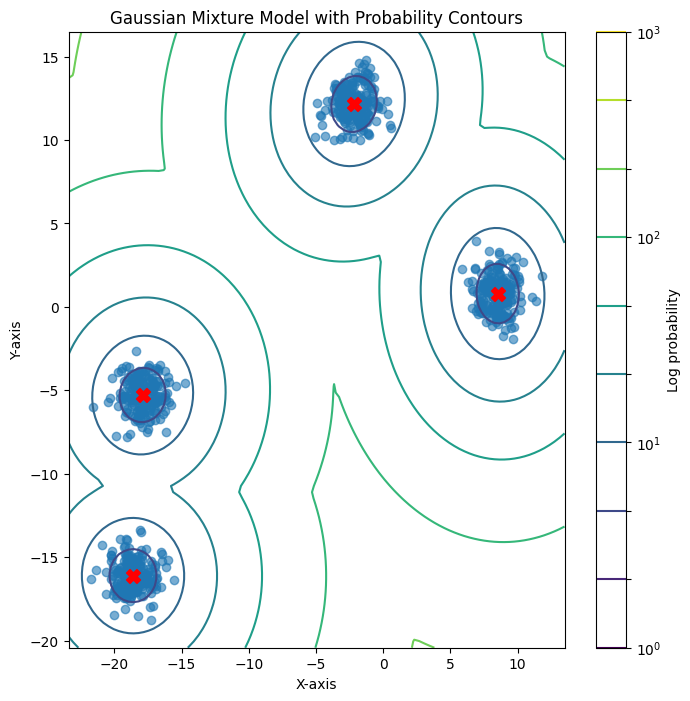

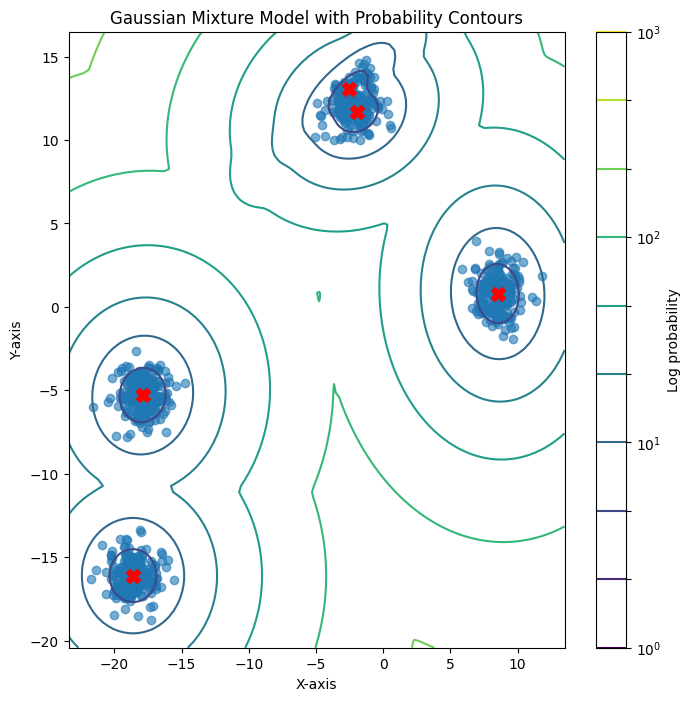

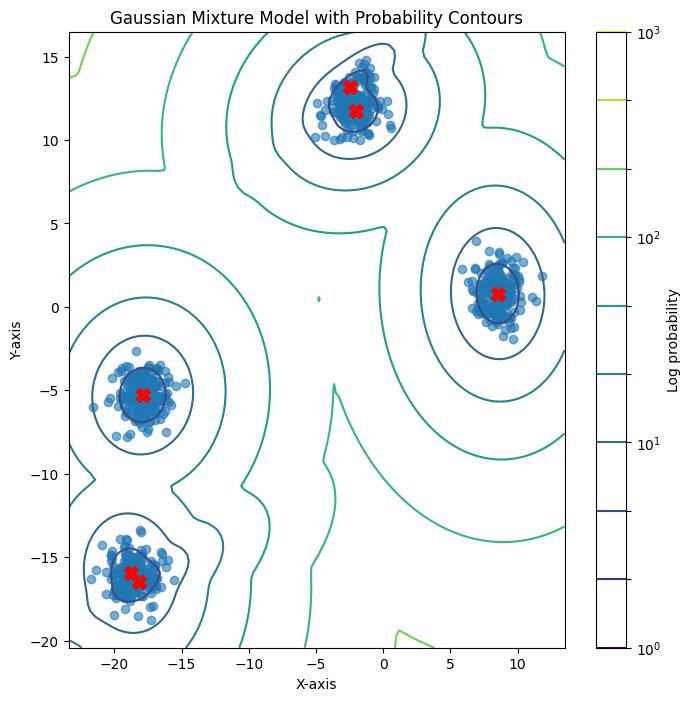

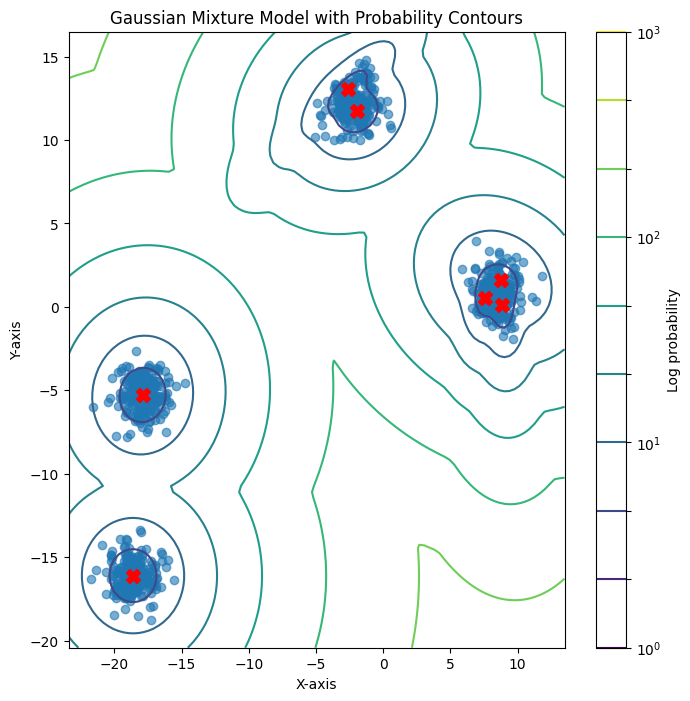

In [39]:
# Algorithms to compare
n_components_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_components_list) // 3 + (len(n_components_list) % 3 > 0)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n in enumerate(n_components_list):
        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        # Plot the contours
        plot_gmm_clusters_with_contours(gm, X)



## 2.3 Clustering hiérarchique 

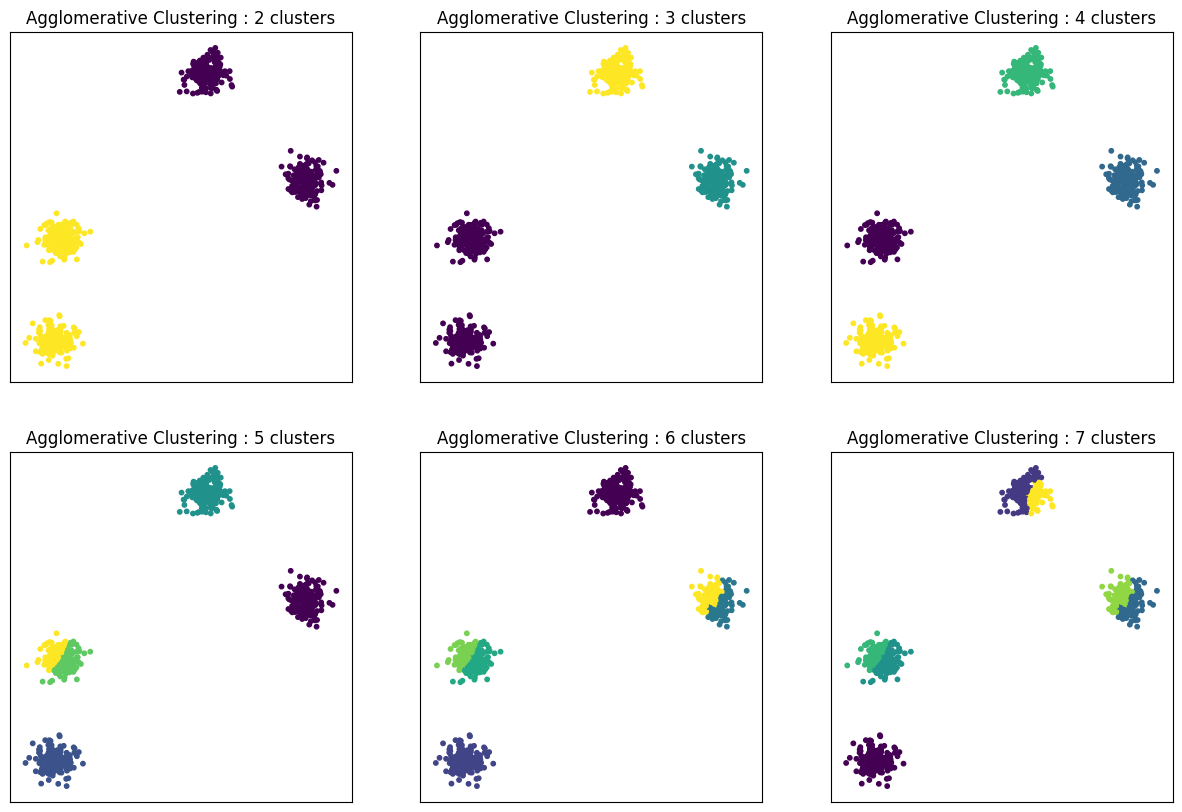

In [40]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
linkage_method = 'ward'
distance_threshold = None
random_state = 0
clustering_algorithms = {
    "Agglomerative Clustering": AgglomerativeClustering,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_clusters_list) // 3 + (len(n_clusters_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        agglomerative = Algorithm(n_clusters=n_clusters, linkage=linkage_method, distance_threshold=distance_threshold)
        agglomerative.fit(X)

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=agglomerative.labels_)

        axs[row, col].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## 2.4 Clustering spectral

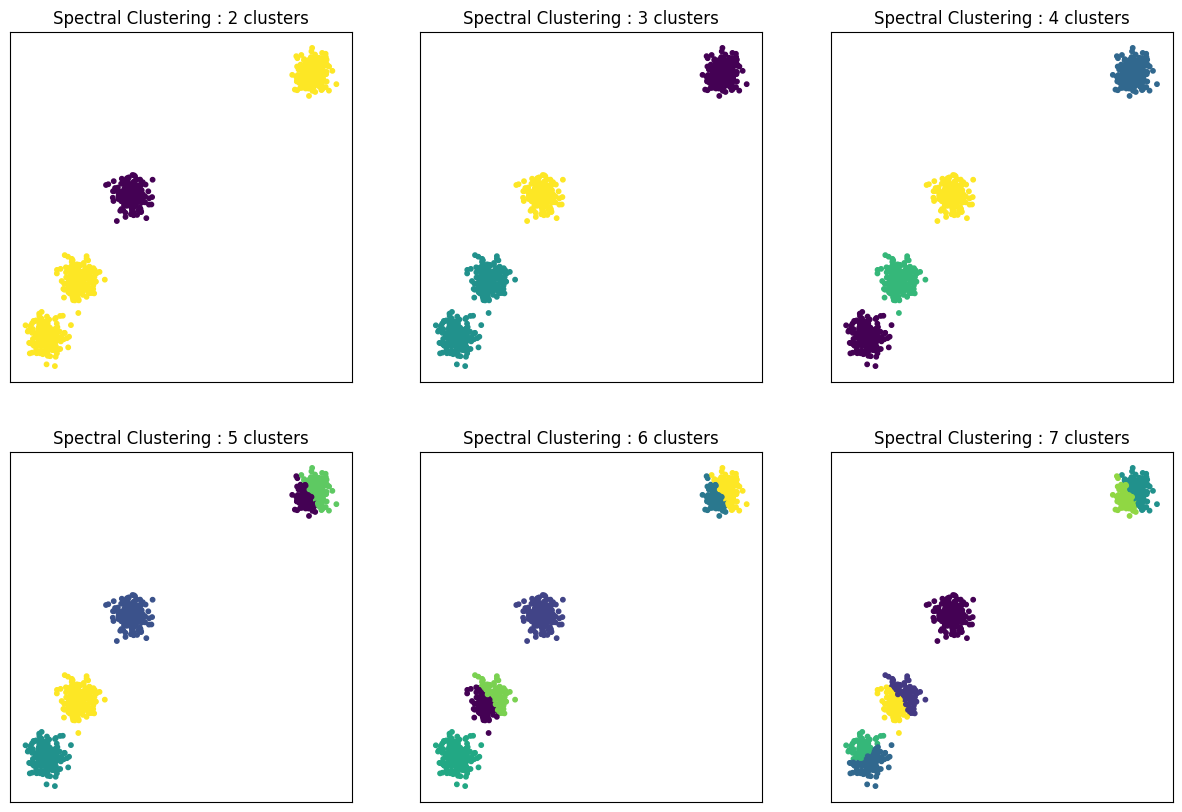

In [26]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
random_state = None
n_init = 10
gamma = 1.0
affinity = 'rbf'
degree = 3
coef0 = 1
clustering_algorithms = {
    "Spectral Clustering": SpectralClustering,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_clusters_list) // 3 + (len(n_clusters_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        spectral_clustering = Algorithm(
            n_clusters=n_clusters,
            random_state=random_state,
            n_init=n_init,
            gamma=gamma,
            affinity=affinity,
            degree=degree,
            coef0=coef0
        )
        spectral_clustering.fit(X)

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=spectral_clustering.labels_)

        axs[row, col].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## 2.5 DEBESCAN

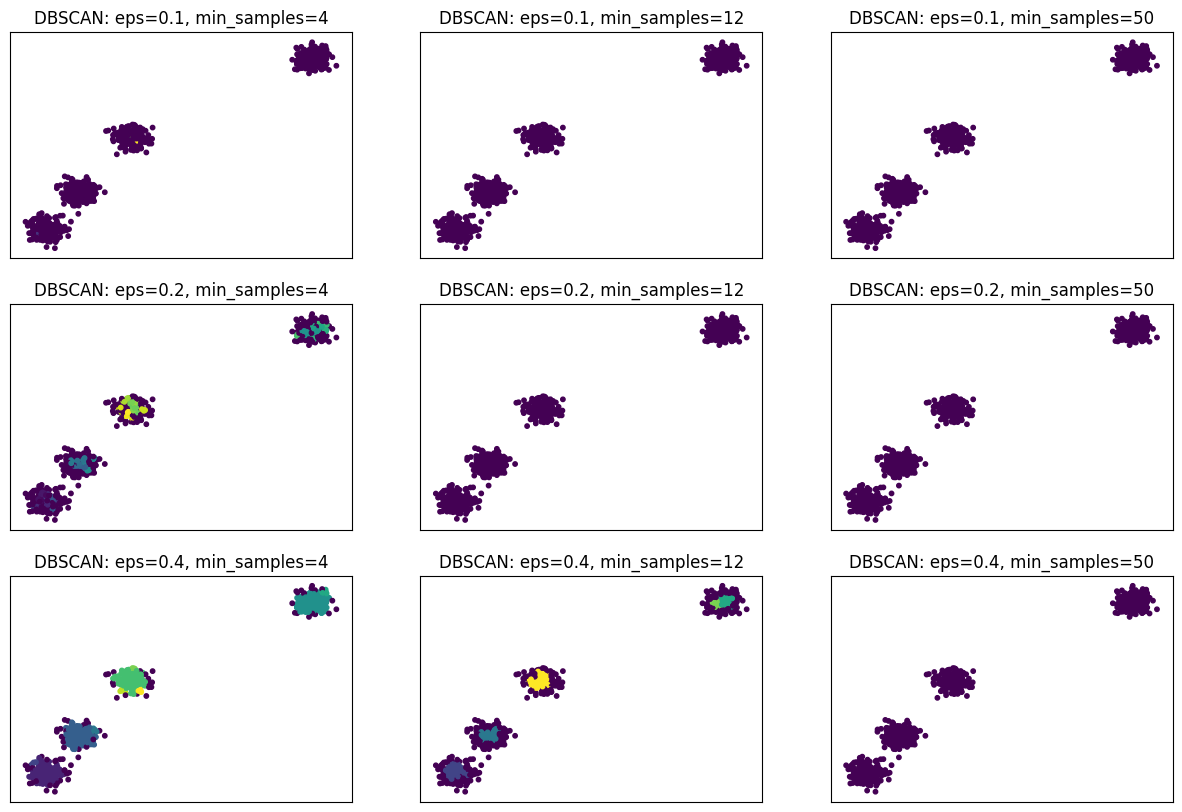

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Parameters to vary
eps_values = [0.1, 0.2, 0.4]
min_samples_values = [4, 12, 50]

# Create a grid of subplots
fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)

        axs[i, j].scatter(X[:, 0], X[:, 1], s=10, c=dbscan.labels_, cmap='viridis')
        axs[i, j].set_title(f"DBSCAN: eps={eps}, min_samples={min_samples}")

# Set common labels and hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


# 3. Comparaison des résultats obtenus sur les données halfmoons (clusters non gaussiens)

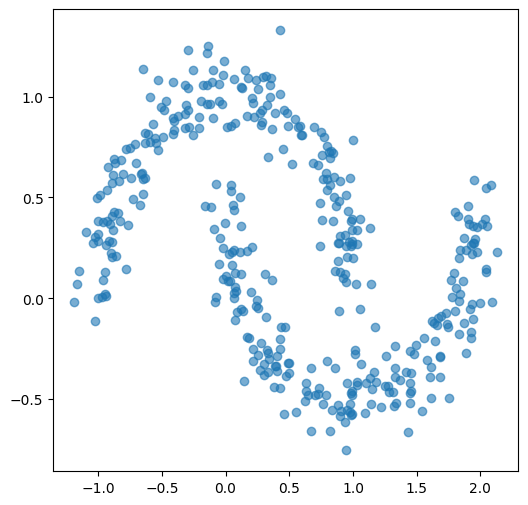

In [29]:
X, y = make_moons(n_samples=400, shuffle=True, noise=0.1)
plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)

## 3.1. Algorithme GMM 

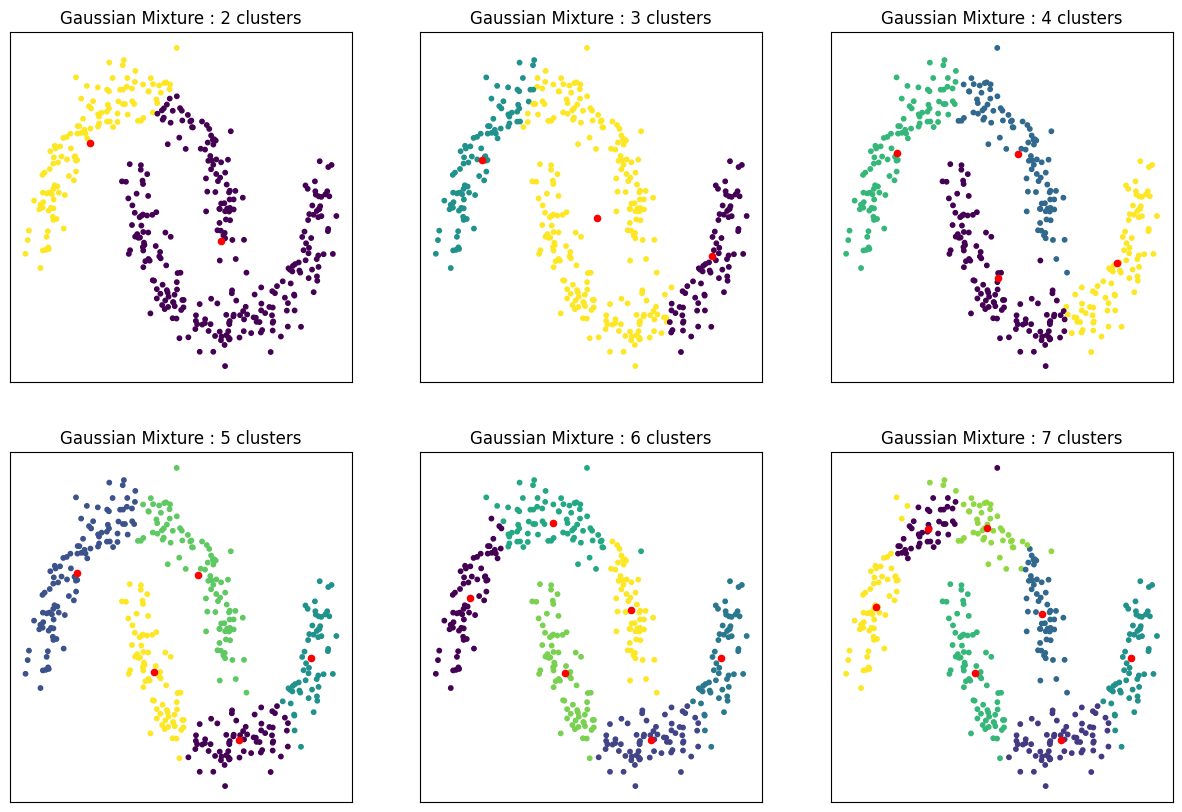

In [30]:
# Algorithms to compare
n_components_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_components_list) // 3 + (len(n_components_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n in enumerate(n_components_list):
        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=gm.predict(X))
        axs[row, col].scatter(means[:, 0], means[:, 1], c="r", s=20)

        axs[row, col].set_title(f"{algorithm_name} : {n} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


#### Avec les lignes de niveaux des fonctions d’affectation pondérée

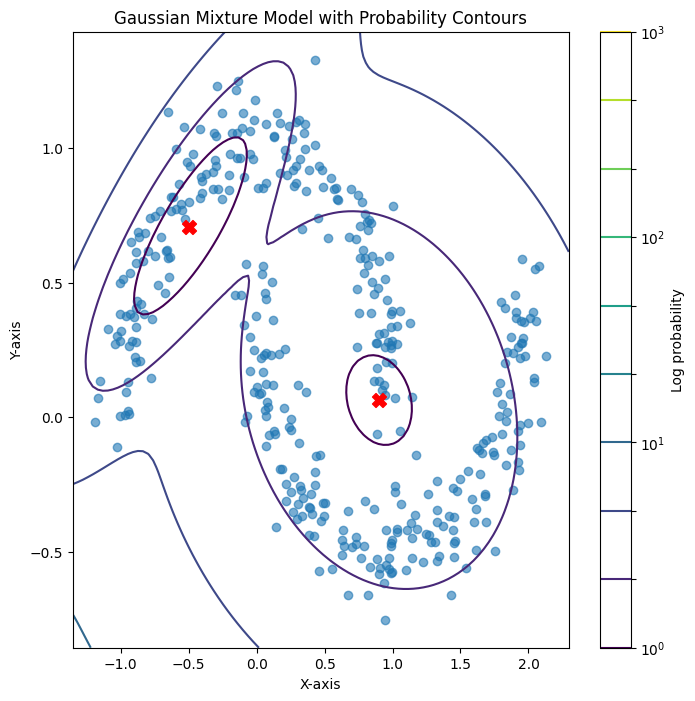

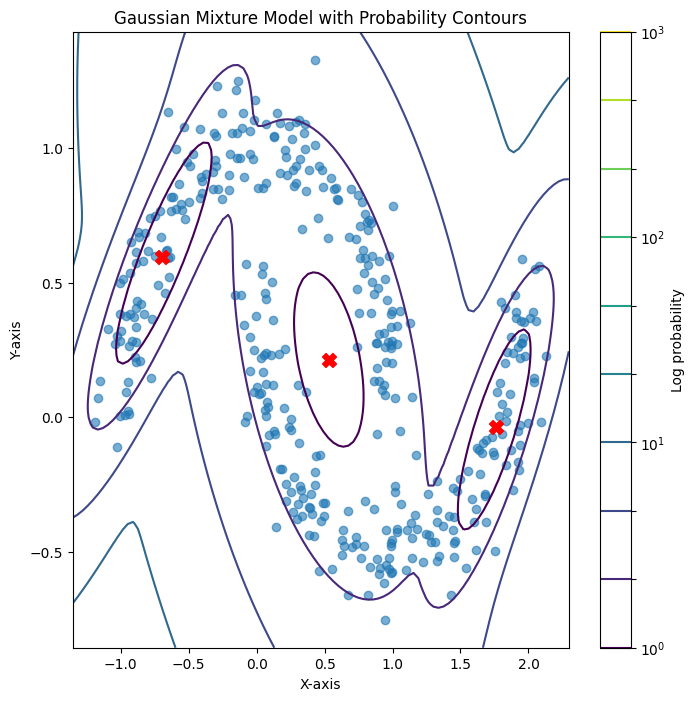

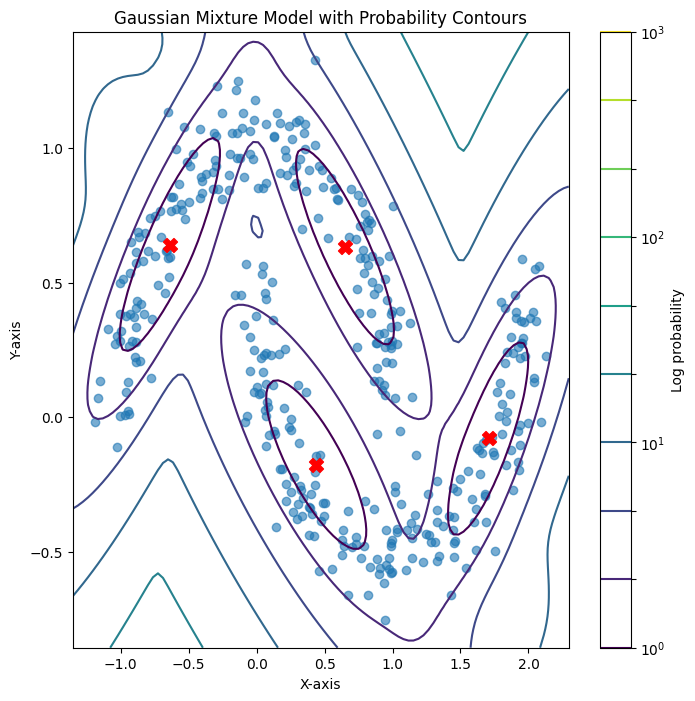

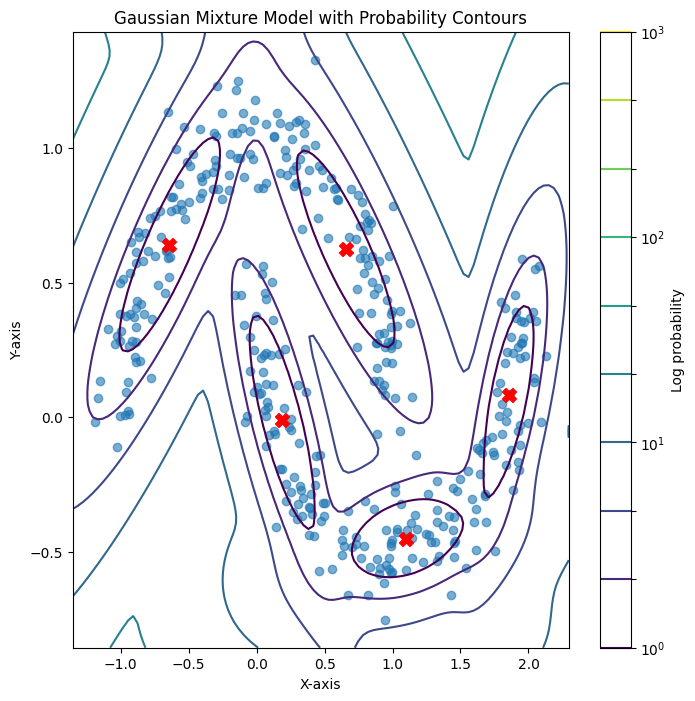

/var/folders/h3/c0mcgvrs30z4p6_jpmc7n46r0000gn/T/ipykernel_14674/1857597480.py:30: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(X_mesh, Y_mesh, Z, levels=np.logspace(0, 3, 10), norm=LogNorm(vmin=1.0, vmax=1000.0), cmap='viridis')


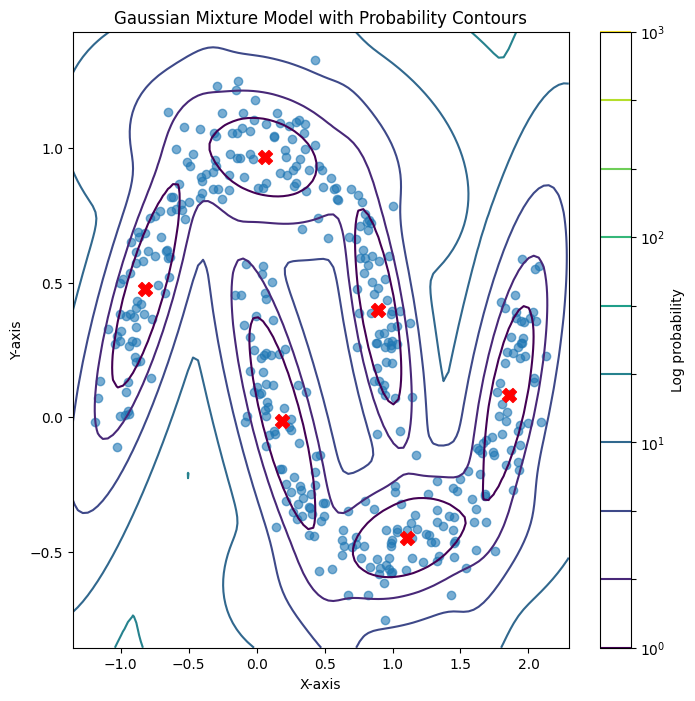

/var/folders/h3/c0mcgvrs30z4p6_jpmc7n46r0000gn/T/ipykernel_14674/1857597480.py:30: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(X_mesh, Y_mesh, Z, levels=np.logspace(0, 3, 10), norm=LogNorm(vmin=1.0, vmax=1000.0), cmap='viridis')


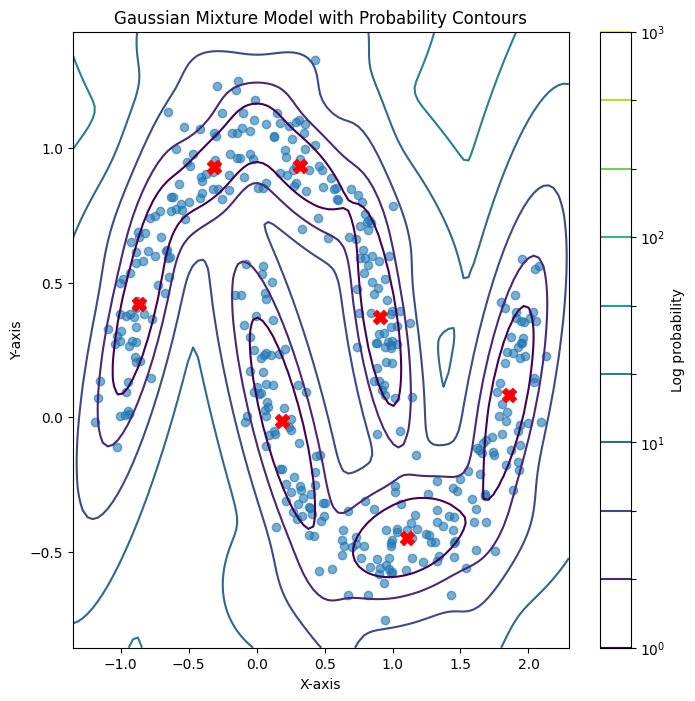

In [31]:
# Algorithms to compare
n_components_list = [2, 3, 4, 5, 6, 7]
random_state = 0
clustering_algorithms = {
    "Gaussian Mixture": GaussianMixture,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_components_list) // 3 + (len(n_components_list) % 3 > 0)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n in enumerate(n_components_list):
        gm = Algorithm(n_components=n, n_init=10, max_iter=100, tol=0.0001, random_state=random_state)
        gm.fit(X)
        means = gm.means_

        # Plot the contours
        plot_gmm_clusters_with_contours(gm, X)



## 3.2. Clustering hiérarchique

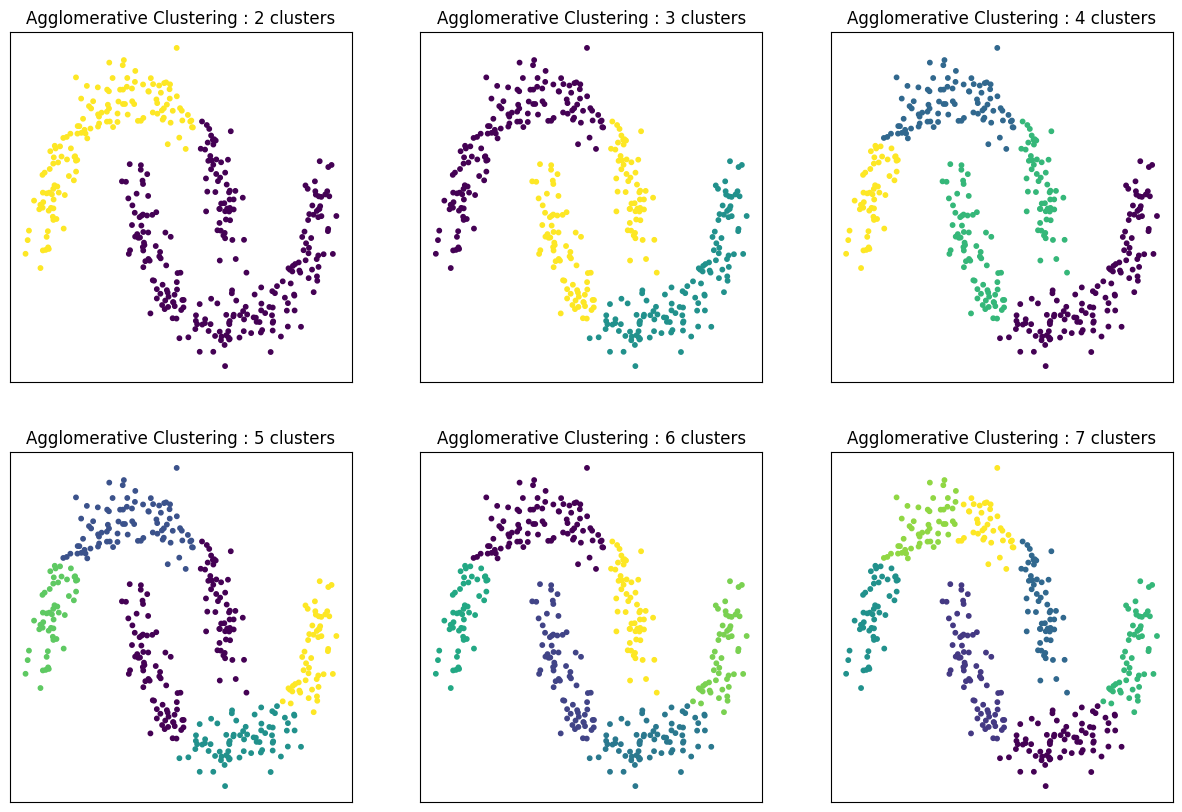

In [32]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
linkage_method = 'ward'
distance_threshold = None
random_state = 0
clustering_algorithms = {
    "Agglomerative Clustering": AgglomerativeClustering,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_clusters_list) // 3 + (len(n_clusters_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        agglomerative = Algorithm(n_clusters=n_clusters, linkage=linkage_method, distance_threshold=distance_threshold)
        agglomerative.fit(X)

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=agglomerative.labels_)

        axs[row, col].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


### 3.3. Clustering spectral

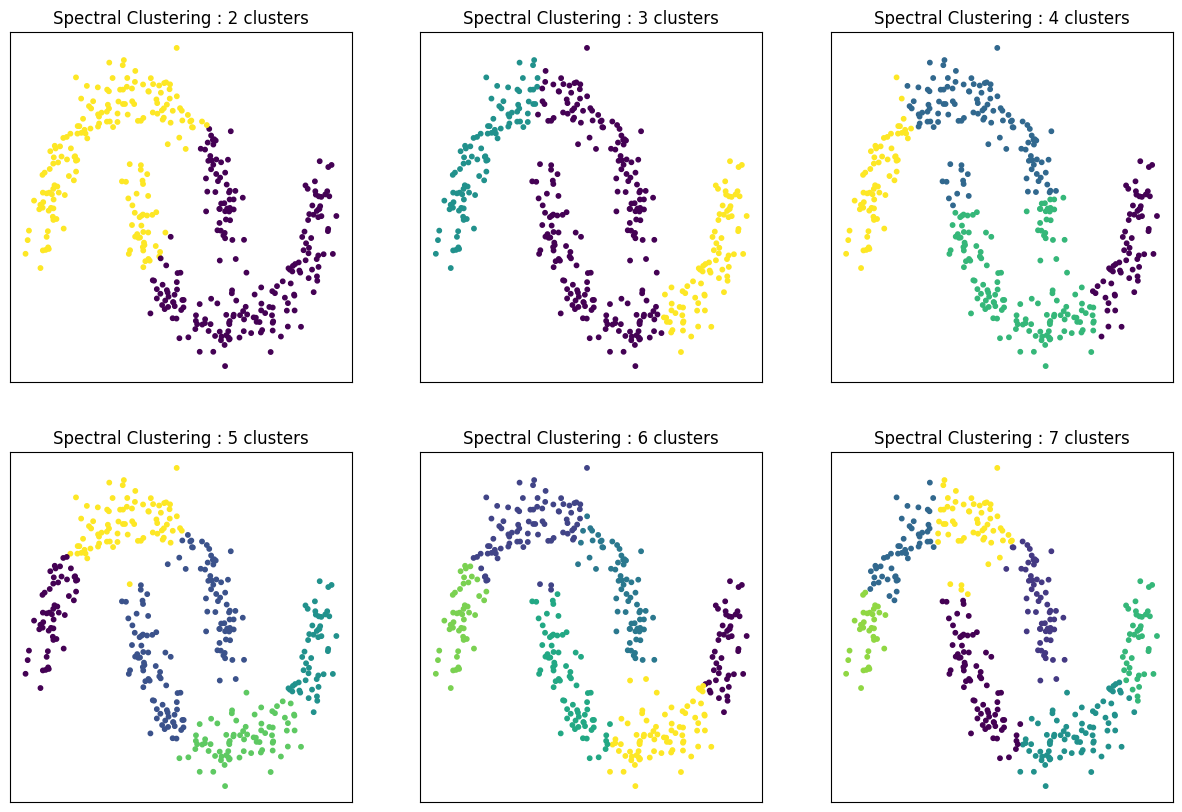

In [33]:
# Algorithms to compare
n_clusters_list = [2, 3, 4, 5, 6, 7]
random_state = None
n_init = 10
gamma = 1.0
affinity = 'rbf'
degree = 3
coef0 = 1
clustering_algorithms = {
    "Spectral Clustering": SpectralClustering,
}

# Calculate the number of rows needed for the subplots
num_rows = len(n_clusters_list) // 3 + (len(n_clusters_list) % 3 > 0)

# Make subplots with 3 graphs per line
fig, axs = plt.subplots(
    num_rows, 3, figsize=(15, 5 * num_rows)
)

for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        spectral_clustering = Algorithm(
            n_clusters=n_clusters,
            random_state=random_state,
            n_init=n_init,
            gamma=gamma,
            affinity=affinity,
            degree=degree,
            coef0=coef0
        )
        spectral_clustering.fit(X)

        row = j // 3
        col = j % 3

        axs[row, col].scatter(X[:, 0], X[:, 1], s=10, c=spectral_clustering.labels_)

        axs[row, col].set_title(f"{algorithm_name} : {n_clusters} clusters")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()


## 3.4. DEBESCAN

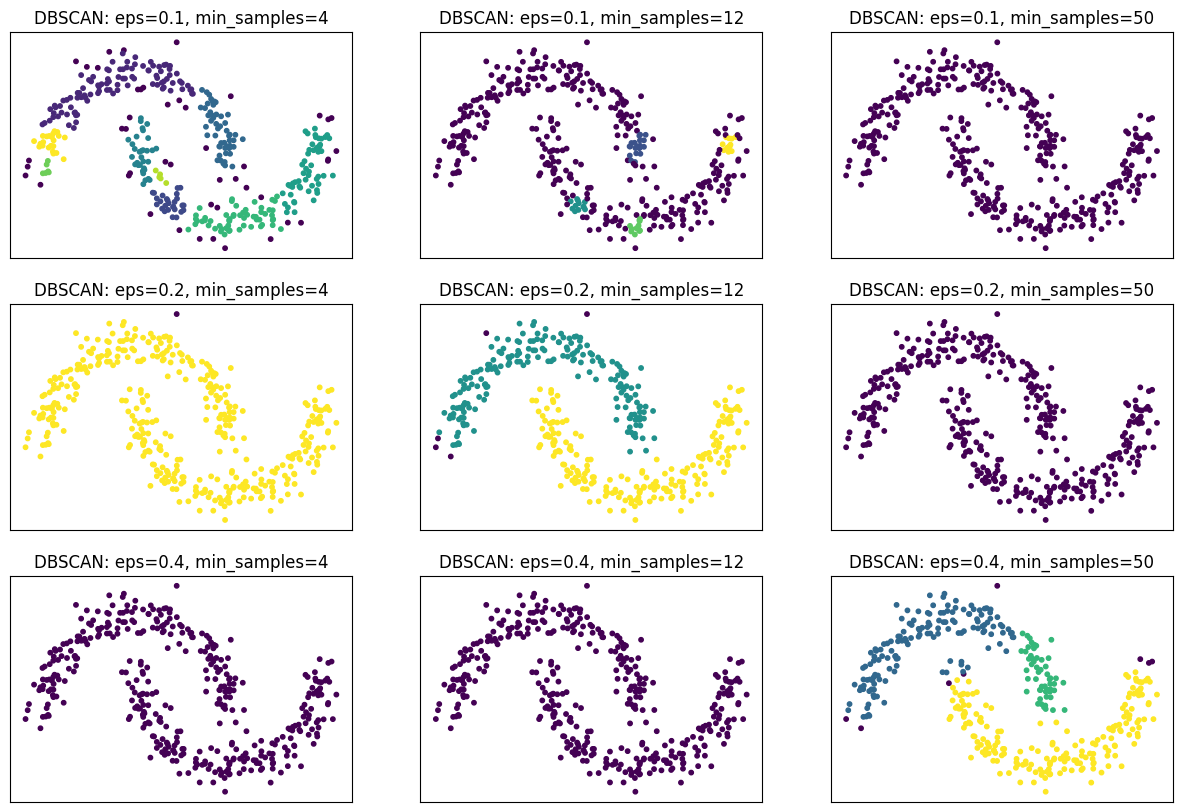

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Parameters to vary
eps_values = [0.1, 0.2, 0.4]
min_samples_values = [4, 12, 50]

# Create a grid of subplots
fig, axs = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 10))

for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)

        axs[i, j].scatter(X[:, 0], X[:, 1], s=10, c=dbscan.labels_, cmap='viridis')
        axs[i, j].set_title(f"DBSCAN: eps={eps}, min_samples={min_samples}")

# Set common labels and hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()
